# BAX Emittance Minimization
In this notebook, we hope to demonstrate Bayesian Algorithm Execution (BAX) in Xopt
as a means of minimizing the emittance at LCLS. BAX is a generalization of Bayesian
Optimization that seeks to acquire observations that provide our model with maximal information about our property of interest. In this example, our property of interest is the minimal emittance and its location in tuning-parameter-space. See https://arxiv.org/pdf/2209.04587.pdf for details.

In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = str(6)

# Imports

In [1]:
# optionally add scripts location to path
if True:
    import sys
    sys.path.append("../../")
    sys.path.append("../")

run_dir = "/home/physics3/ml_tuning/20231009_LCLS_Injector/"
print(sys.path)


2.0a1+47.g1d5b3d1


# Set up image diagnostic

In [ ]:
from scripts.image import ImageDiagnostic
import yaml

fname = "../OTR3_config.yml"
image_diagnostic = ImageDiagnostic.parse_obj(yaml.safe_load(open(fname)))
image_diagnostic.save_image_location = run_dir
image_diagnostic.n_fitting_restarts = 2
image_diagnostic.visualize = False
image_diagnostic.background_file = run_dir + "OTRS_IN20_621_background.npy"
print(image_diagnostic.yaml())

In [ ]:
image_diagnostic.background_file

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image_diagnostic.background_image)

In [ ]:
image_diagnostic.test_measurement()

# Define VOCS

In [ ]:
import pandas as pd
from xopt.vocs import VOCS

In [ ]:
filename = "../variables.csv"
VARIABLE_RANGES = pd.read_csv(filename, index_col=0, header=None).T.to_dict(orient='list')

IMAGE_CONSTRAINTS = {
    "bb_penalty": ["LESS_THAN", 0.0],
    "log10_total_intensity": ["GREATER_THAN", image_diagnostic.min_log_intensity]
}

In [ ]:
VARIABLES = ["SOLN:IN20:121:BCTRL", "QUAD:IN20:121:BCTRL", "QUAD:IN20:122:BCTRL",
             "QUAD:IN20:361:BCTRL", "QUAD:IN20:371:BCTRL", "QUAD:IN20:425:BCTRL",
             "QUAD:IN20:441:BCTRL"  , "QUAD:IN20:511:BCTRL", "QUAD:IN20:525:BCTRL"]

# get dimension index for measurement device
meas_param = 'QUAD:IN20:525:BCTRL' # assign measurement parameter
MEAS_DIM = list(vocs.variables).index(meas_param)
print('MEAS_DIM =', MEAS_DIM)

vocs = VOCS(
    variables = {ele: VARIABLE_RANGES[ele] for ele in VARIABLES},
    constraints = IMAGE_CONSTRAINTS,
    observables = ["xrms_sq", "yrms_sq"]
)
print(vocs.as_yaml())

# Define evaluate function

In [ ]:
from time import sleep

import torch
import numpy as np
from epics import caput, caget_many

In [ ]:
def eval_beamsize(input_dict, generator = None):
    global image_diagnostic
    # set PVs
    for k, v in input_dict.items():
        print(f'CAPUT {k} {v}')
        caput(k, v)

    sleep(2.0)

    # get beam sizes from image diagnostic
    metadata = input_dict
    results = image_diagnostic.measure_beamsize(3, **metadata)
    results["S_x_mm"] = np.array(results["Sx"]) * 1e-3
    results["S_y_mm"] = np.array(results["Sy"]) * 1e-3

    # get other PV's NOTE: Measurements not synchronous with beamsize measurements!
    results = results

    # add beam size squared for bax
    results["xrms_sq"] = np.array(results["Sx"]) ** 2
    results["yrms_sq"] = np.array(results["Sy"]) ** 2
    
    return results

# Restrict ranges based on profile monitor

In [ ]:
vocs.variables = {k: input_variables[k].value_range for k in vocs.variable_names}
vocs.variables["SOLN:IN20:121:BCTRL"] = [0.467, 0.479]
print(vocs.as_yaml())

# Product kernel model constructor

In [7]:
from gpytorch.kernels import MaternKernel, PolynomialKernel, ScaleKernel
from gpytorch.priors.torch_priors import GammaPrior

from xopt.generators.bayesian.models.standard import StandardModelConstructor

# prepare custom covariance module
tuning_dims = list(range(vocs.n_variables))
tuning_dims.remove(MEAS_DIM)
covar_module_x = (MaternKernel(ard_num_dims=len(tuning_dims), 
                              active_dims=tuning_dims, 
                              lengthscale_prior=None) * 
                              PolynomialKernel(power=2, active_dims=[MEAS_DIM])
                 )

scaled_covar_module_x = ScaleKernel(covar_module_x)
covar_module_y = (MaternKernel(ard_num_dims=len(tuning_dims), 
                              active_dims=tuning_dims, 
                              lengthscale_prior=None) * 
                              PolynomialKernel(power=2, active_dims=[MEAS_DIM])
                 )
scaled_covar_module_y =  ScaleKernel(covar_module_y)

# prepare options for Xopt generator
covar_module_dict = {'xrms_sq': scaled_covar_module_x,
                     'yrms_sq': scaled_covar_module_y}

model_constructor = StandardModelConstructor(covar_modules=covar_module_dict, use_low_noise_prior=False)

meas_dim = 8


# Acquisition func minimizer options

In [ ]:
from xopt.numerical_optimizer import LBFGSOptimizer
numerical_optimizer = LBFGSOptimizer(n_restarts=10,
                                    max_iter=50)

# BAX algorithm

In [8]:
from emitopt.beam_dynamics import get_quad_scale_factor
from emitopt.algorithms import ScipyMinimizeEmittanceXY

QUAD_LENGTH = 0.108 # m
BEAM_ENERGY = 0.135 # GeV
SCALE_FACTOR = get_quad_scale_factor(E=BEAM_ENERGY, q_len=QUAD_LENGTH)
RMAT_X = torch.tensor([]) # NEED TO DEFINE
RMAT_Y = torch.tensor([]) # NEED TO DEFINE

#Prepare Algorithm
algo_kwargs = {
        'x_key': 'xrms_sq',
        'y_key': 'yrms_sq',
        'scale_factor': SCALE_FACTOR,
        'q_len': QUAD_LENGTH,
        'rmat_x': RMAT_X,
        'rmat_y': RMAT_Y,
        'n_samples': 10,
        'meas_dim': MEAS_DIM,
        'n_steps_measurement_param': 11,
#         'scipy_options': None,
        'thick_quad': False,
}
algo = ScipyMinimizeEmittanceXY(**algo_kwargs)

# Construct generator, evaluator, Xopt objects

In [9]:
from xopt.generators.bayesian.bax_generator import BaxGenerator
from xopt.evaluator import Evaluator
from xopt import Xopt

#construct BAX generator
generator = BaxGenerator(vocs=vocs, 
                         gp_constructor=model_constructor, 
                         numerical_optimizer=numerical_optimizer,
                         algorithm=algo)

#construct evaluator
evaluator = Evaluator(function=eval_beamsize)

#construct Xopt optimizer
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

# Optimize

CAPUT SOLN:IN20:121:BCTRL 0.4734600764678699
CAPUT QUAD:IN20:121:BCTRL 0.0019403282214516928
CAPUT QUAD:IN20:122:BCTRL 0.008860540978864725
CAPUT QUAD:IN20:361:BCTRL -3.186779092572007
CAPUT QUAD:IN20:371:BCTRL 2.918788509732356
CAPUT QUAD:IN20:425:BCTRL -1.7120108869000408
CAPUT QUAD:IN20:441:BCTRL -2.0793689121448082
CAPUT QUAD:IN20:511:BCTRL 2.608280973678731
CAPUT QUAD:IN20:525:BCTRL 3.7284002829872254
CAPUT SOLN:IN20:121:BCTRL 0.4796111065225816
CAPUT QUAD:IN20:121:BCTRL 0.002388965937375329
CAPUT QUAD:IN20:122:BCTRL -0.0035781289905199116
CAPUT QUAD:IN20:361:BCTRL -3.4347936829385066
CAPUT QUAD:IN20:371:BCTRL 2.712613502031434
CAPUT QUAD:IN20:425:BCTRL -2.1238517558369328
CAPUT QUAD:IN20:441:BCTRL 2.522127137945634
CAPUT QUAD:IN20:511:BCTRL 0.43126603441566314
CAPUT QUAD:IN20:525:BCTRL -0.9674530897859581
CAPUT SOLN:IN20:121:BCTRL 0.4717550628318194
CAPUT QUAD:IN20:121:BCTRL 0.0050899553698837766
CAPUT QUAD:IN20:122:BCTRL 0.006010359789764306
CAPUT QUAD:IN20:361:BCTRL -3.37039946

,SOLN:IN20:121:BCTRL,QUAD:IN20:121:BCTRL,QUAD:IN20:122:BCTRL,QUAD:IN20:361:BCTRL,QUAD:IN20:371:BCTRL,QUAD:IN20:425:BCTRL,QUAD:IN20:441:BCTRL,QUAD:IN20:511:BCTRL,QUAD:IN20:525:BCTRL,screen,...,Sy,bb_penalty,total_intensity,log10_total_intensity,time,S_x_mm,S_y_mm,total_size,xopt_runtime,xopt_error
1,0.473460,0.001940,0.008861,-3.186779,2.918789,-1.712011,-2.079369,2.608281,3.728400,OTRS:IN20:621,...,NaN,59.670986,3092.562674,3.490319,1.690677e+09,NaN,NaN,NaN,5.197434,False
2,0.479611,0.002389,-0.003578,-3.434794,2.712614,-2.123852,2.522127,0.431266,-0.967453,OTRS:IN20:621,...,229.892617,-203.632334,15605.755898,4.193285,1.690677e+09,0.216331,0.229893,315.673594,4.508756,False
3,0.471755,0.005090,0.006010,-3.370399,2.891665,0.034579,-0.031477,2.420815,2.739880,OTRS:IN20:621,...,570.183381,-177.965996,5043.251299,3.702711,1.690677e+09,0.269892,0.570183,630.833187,4.492667,False


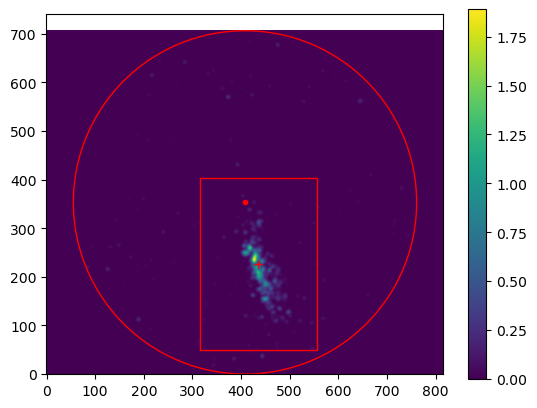

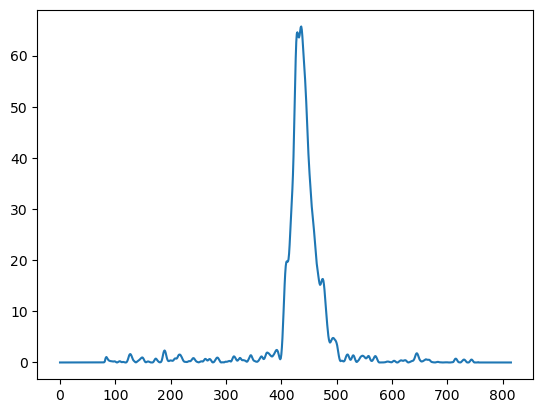

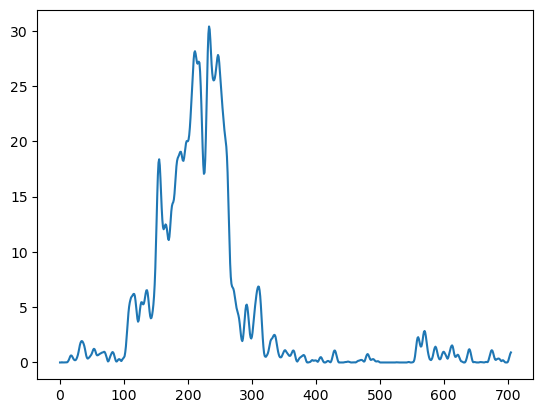

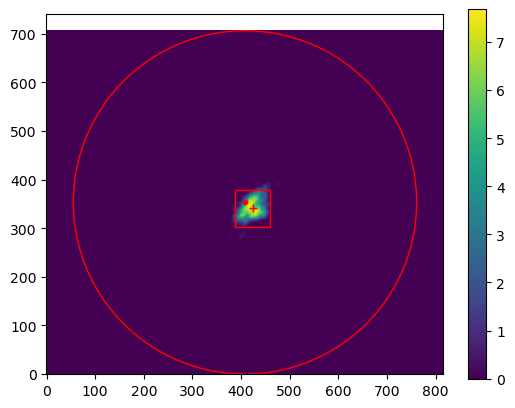

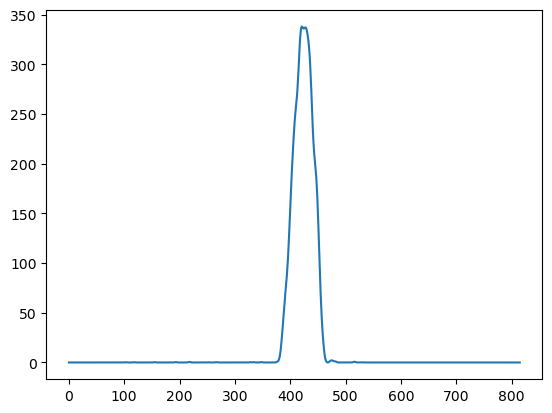

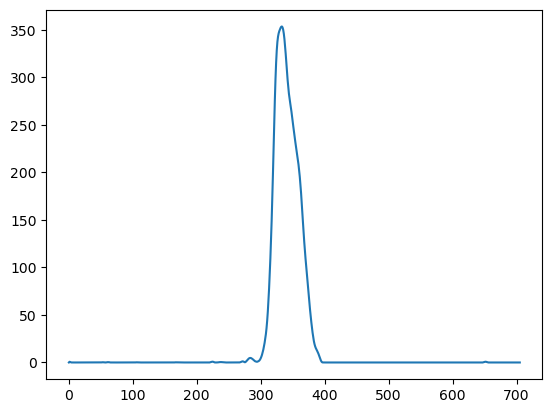

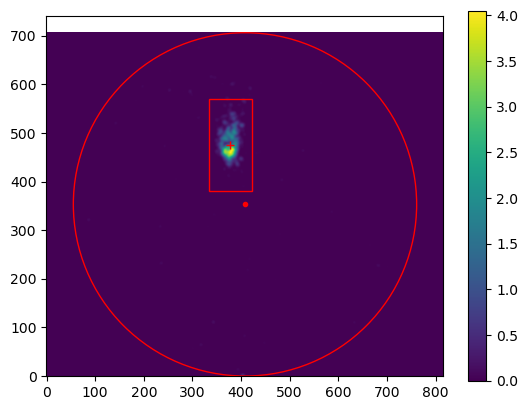

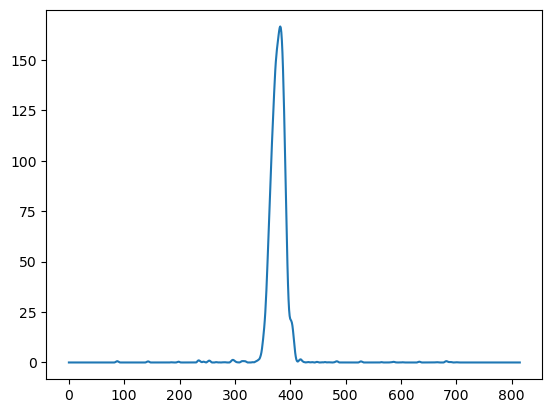

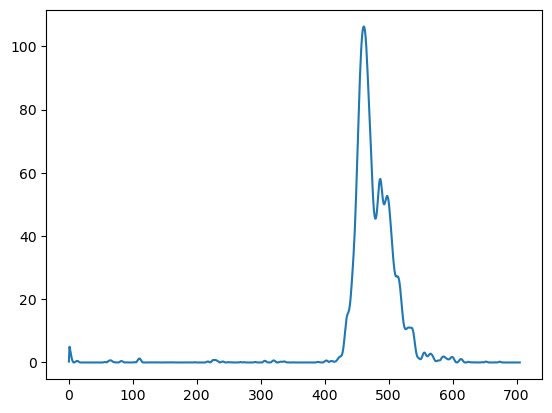

In [10]:
# call X.random_evaluate() to generate random initial points and evaluate on test_func
X.random_evaluate(3, seed=0)

In [ ]:
results = {}

%%time
for i in range(10):
    print(i)
    X.step()
    results[i] = X.generator.algorithm_results

In [ ]:
from emitopt.plot_utils import (plot_sample_optima_convergence_emits
                                plot_sample_optima_convergence_inputs
                                plot_pathwise_emittance_vs_tuning
                                plot_virtual_emittance_vs_tuning
                                plot_virtual_measurement_scan
                               )

In [ ]:
fig, ax = plot_sample_optima_convergence_emits(results)

In [ ]:
fig, axes = plot_sample_optima_convergence_inputs(results)

In [ ]:
best_tuning_configs = X.generator.algorithm_results['x_tuning_best']
tuning_config = best_tuning_configs.mean(dim=0)

In [ ]:
fig, axes = plot_pathwise_emittance_vs_tuning(X, x_origin=tuning_config)

In [ ]:
fig, axes = plot_virtual_emittance_vs_tuning(X, x_origin=tuning_config)

In [ ]:
fig, ax = plot_virtual_measurement_scan(X, x_tuning=tuning_config)